# Import necessary packages

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, f1_score, accuracy_score)
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [3]:
df = pd.read_csv('/kaggle/input/credit-card-fraud-detection/creditcard.csv')

# Check for missing values

In [4]:
assert df.isnull().sum().sum() == 0, "Dataset contains missing values."

# Drop 'Time' column (not relevant to fraud detection)

In [5]:
df.drop('Time', axis=1, inplace=True)

# Class distribution

In [6]:
classes = df['Class'].value_counts()
fraud_percentage = round((classes[1] / len(df)) * 100, 2)
print(f"Fraudulent transactions: {fraud_percentage}%")

Fraudulent transactions: 0.17%


# Visualize class distribution

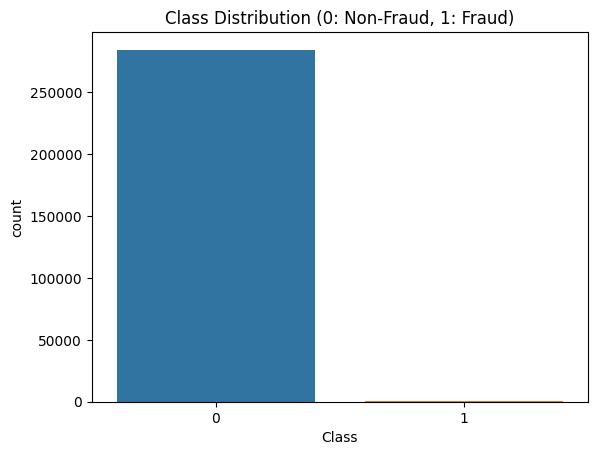

In [7]:
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.show()

# Train-test split

In [8]:
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling

In [9]:
scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
X_test['Amount'] = scaler.transform(X_test[['Amount']])

# Power Transformation to mitigate skewness

In [10]:
transformer = PowerTransformer(method='yeo-johnson', standardize=True)
X_train = pd.DataFrame(transformer.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(transformer.transform(X_test), columns=X.columns)

# Handle class imbalance (undersampling)

In [12]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Logistic Regression with hyperparameter tuning

In [13]:
logistic_params = {"C": [0.01, 0.1, 1, 10, 100]}
logistic = LogisticRegression(random_state=42)
cv = GridSearchCV(estimator=logistic, param_grid=logistic_params, scoring='roc_auc', cv=5, verbose=1)
cv.fit(X_train_rus, y_train_rus)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='roc_auc',
             verbose=1)

# Best Logistic Regression Model

In [14]:
best_logistic = cv.best_estimator_
print(f"Best Logistic Regression parameters: {cv.best_params_}")

Best Logistic Regression parameters: {'C': 0.01}


# Logistic Regression Evaluation

In [15]:
train_pred_proba = best_logistic.predict_proba(X_train_rus)[:, 1]
test_pred_proba = best_logistic.predict_proba(X_test)[:, 1]

# Function to visualize data distribution

In [28]:
def plot_distribution(df, column, title):
    plt.figure(figsize=(8, 5))
    sns.histplot(df[column], kde=True, stat="density", label=column)
    plt.title(title)
    plt.legend()
    plt.show()

# Function to plot ROC curve

In [19]:
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Train Metrics

Logistic Regression - Train Metrics:


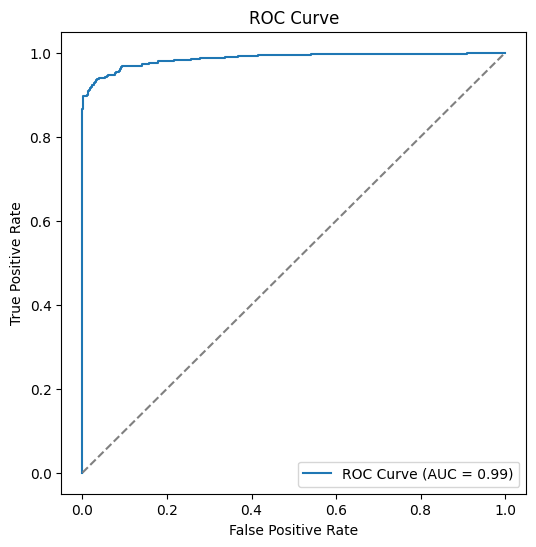

              precision    recall  f1-score   support

           0       0.90      1.00      0.94       394
           1       1.00      0.88      0.94       394

    accuracy                           0.94       788
   macro avg       0.95      0.94      0.94       788
weighted avg       0.95      0.94      0.94       788



In [20]:
print("Logistic Regression - Train Metrics:")
plot_roc_curve(y_train_rus, train_pred_proba)
print(classification_report(y_train_rus, best_logistic.predict(X_train_rus)))

# Test Metrics

Logistic Regression - Test Metrics:


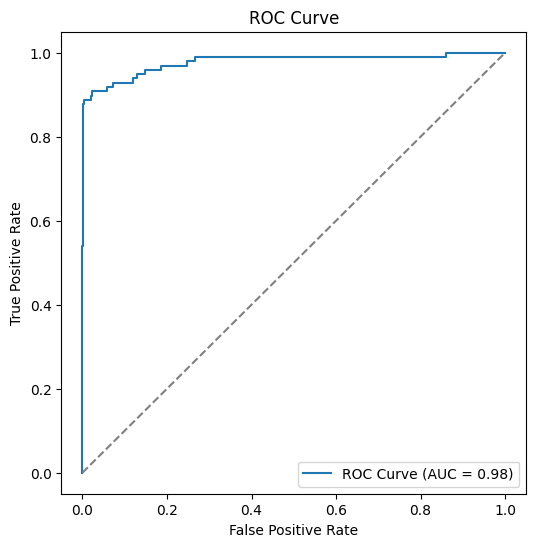

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.89      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962



In [21]:
print("Logistic Regression - Test Metrics:")
plot_roc_curve(y_test, test_pred_proba)
print(classification_report(y_test, best_logistic.predict(X_test)))

# XGBoost Classifier with hyperparameter tuning

In [22]:
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8],
    'max_depth': [3, 5],
    'n_estimators': [100, 200]
}
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
cv_xgb = GridSearchCV(estimator=xgb, param_grid=xgb_params, scoring='roc_auc', cv=5, verbose=1)
cv_xgb.fit(X_train_rus, y_train_rus)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.6, 0.8]},
             scoring='roc_auc', verbose=1)

# Best XGBoost Model

In [23]:
best_xgb = cv_xgb.best_estimator_
print(f"Best XGBoost parameters: {cv_xgb.best_params_}")

Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


# XGBoost Evaluation

In [24]:
xgb_train_pred_proba = best_xgb.predict_proba(X_train_rus)[:, 1]
xgb_test_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Train Metrics

XGBoost - Train Metrics:


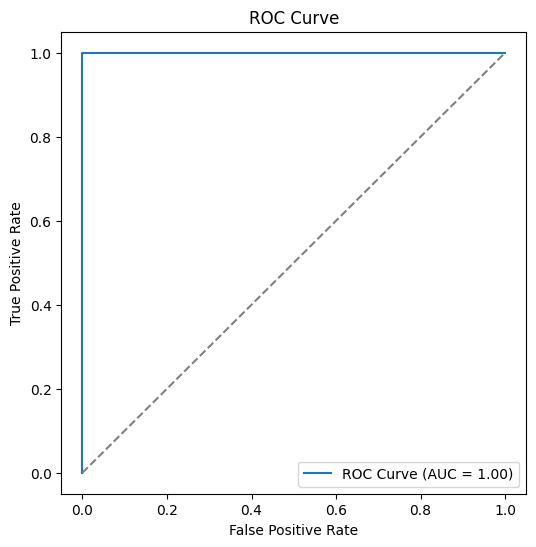

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00       394

    accuracy                           1.00       788
   macro avg       1.00      1.00      1.00       788
weighted avg       1.00      1.00      1.00       788



In [25]:
print("XGBoost - Train Metrics:")
plot_roc_curve(y_train_rus, xgb_train_pred_proba)
print(classification_report(y_train_rus, best_xgb.predict(X_train_rus)))

# Test Metrics

XGBoost - Test Metrics:


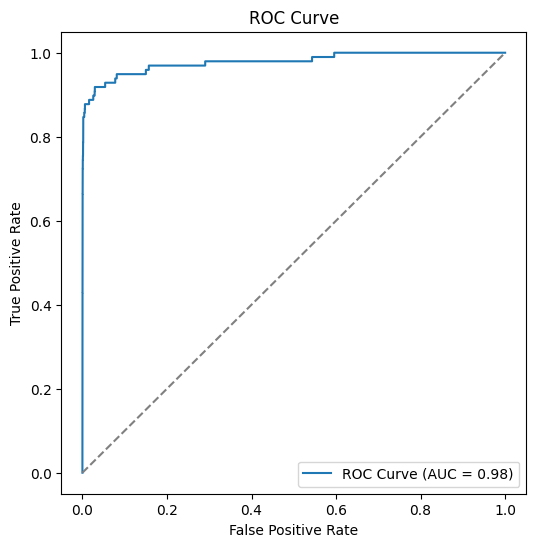

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.96      0.98     56962



In [26]:
print("XGBoost - Test Metrics:")
plot_roc_curve(y_test, xgb_test_pred_proba)
print(classification_report(y_test, best_xgb.predict(X_test)))

# Feature importance (XGBoost)

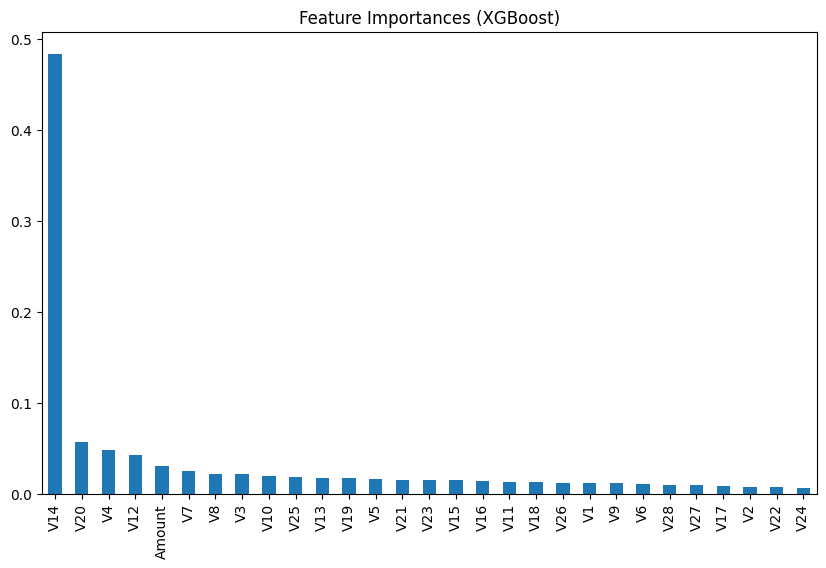

In [27]:
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot(kind='bar')
plt.title('Feature Importances (XGBoost)')
plt.show()

# Final Summary

In [30]:
print("Summary:")
print(f"Logistic Regression Test AUC: {roc_auc_score(y_test, test_pred_proba):.2f}")
print(f"XGBoost Test AUC: {roc_auc_score(y_test, xgb_test_pred_proba):.2f}")

Summary:
Logistic Regression Test AUC: 0.98
XGBoost Test AUC: 0.98


# Save the Logistic Regression model, scaler, and transformer

In [33]:
with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_logistic, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

with open('transformer.pkl', 'wb') as transformer_file:
    pickle.dump(transformer, transformer_file)